In [4]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [5]:
# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 100

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 100

from os import walk

### Matrix and fit for non-bary-centric data to show earth movement and the usage of the matrix reduction

In [6]:
filename = "lily_data_results/all_features_34411_ms_non_bary.npy"
result, coords = np.load(filename, allow_pickle=True)
result = filter_z_test_result(result)
diff_matrix, diff_matrix_err, diff_matrix_valid = parse_matrix_results(result, coords)
m, final_shifts, final_shifts_err = matrix_reduce_results_file(filename, plot=False)

/Users/jakobharteg/GitHub/bachelor-project/radial_velocity_functions.py:848: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  shift_mean, shift_mean_err = weighted_mean(shifts_list[shifts_valid_list == 1], shifts_err_list[[shifts_valid_list == 1]])


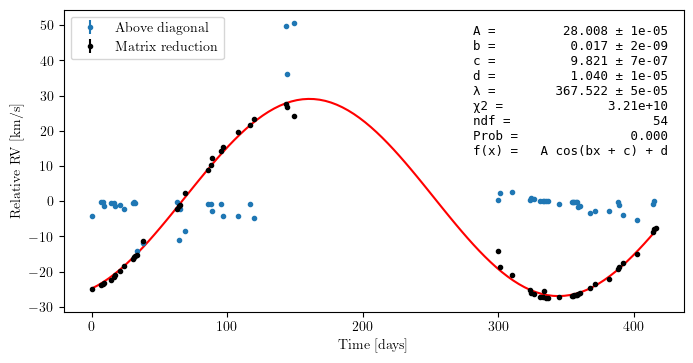

In [8]:
c = 299792458

# The velocity shifts are between days, so let's put the x-error bar as the time span for each data point
velocity_shifts = get_above_diagonal(diff_matrix) * 1/1000 # km/s
velocity_shifts_err = get_above_diagonal(diff_matrix_err) * 1/1000 # km/s
dates = get_spectra_dates(get_spectra_filenames_without_duplicate_dates())
days = convert_dates_to_relative_days(dates)

fig, (ax1) = plt.subplots(ncols=1, figsize=(8, 4))

ax1.set_xlabel("Time [days]")
ax1.set_ylabel("Relative RV [km/s]")
ax1.errorbar(days[:-1], velocity_shifts, yerr=velocity_shifts_err, fmt=".", color="C0", label="Above diagonal")

# Fit
x = days
y = np.asarray(final_shifts[:]) * 1/1000 # km/s
y_err = np.asarray(final_shifts_err[:]) * 1/1000 # km/s
ax1.errorbar(x, y, yerr=y_err, fmt=".", color="k", label="Matrix reduction")

# Fitting functions:
def func(x, a, b, c, d) :
    return a * np.cos(x * b + c) + d


# ChiSquare fit model:
def model_chi(a, b, c, d) :
    y_fit = func(x, a, b, c, d)
    chi2 = np.sum(((y - y_fit) / y_err)**2)
    return chi2
model_chi.errordef = 1

minuit = Minuit(model_chi, a=30000, b=0.01, c=3.5, d=1040)
m = minuit.migrad()        
                    
# Plot result
xPeak = np.linspace(x[0], x[len(x)-1], 100)
ax1.plot(xPeak, func(xPeak, *minuit.values[:]), '-r')

Npoints = len(x)
Nvar = 4                                        # Number of variables
Ndof_fit = Npoints - Nvar                       # Number of degrees of freedom = Number of data points - Number of variables
Chi2_fit = minuit.fval                          # The chi2 value
Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom

a, a_err = minuit.values['a'], minuit.errors['a']
b, b_err = minuit.values['b'], minuit.errors['b']
c, c_err = minuit.values['c'], minuit.errors['c']
d, d_err = minuit.values['d'], minuit.errors['d']
wavel, wavel_err = (2 * np.pi)/b, np.sqrt((2 * np.pi)**2*b_err**2/b**4)

d = {'A = ':   [a, f"{a_err:.1}"],
    'b = ':    [b, f"{b_err:.1}"],
    'c = ':    [c, f"{c_err:.1}"],
    'd = ':    [d, f"{d_err:.1}"],
    'λ = ':    [wavel, f"{wavel_err:.1}"],
    'χ2 = ':     f"{Chi2_fit:.3}",
    'ndf = ':      Ndof_fit,
    'Prob = ':     Prob_fit,
    'f(x) = ':     "A cos(bx + c) + d"
}

matplotlib.rcParams["text.usetex"] = False
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.66, 0.95, text, ax1, fontsize=9, color='black')
matplotlib.rcParams["text.usetex"] = True
ax1.legend(loc = "upper left")

fig.savefig("shift_non_bary_centric.pdf", bbox_inches="tight", dpi=300)